<a href="https://colab.research.google.com/github/milagrosonofri/Problem_Set_1/blob/main/PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Obtención y limpieza de la base de datos

In [1]:
# Importamos las librerías necesarias
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

Web Scraping

In [2]:
# Armamos una lista para almacenar todos los datos
data = []

# Base URL de las páginas
base_url = 'https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html'

# Iteramos sobre las 10 páginas
for i in range(1, 11):

    # Construimos la URL de la página actual
    url = base_url.format(i)

    # Enviamos solicitud HTTP
    response = requests.get(url)
    print(f"Scraping página {i}: {response}")  # Confirmar que la solicitud es exitosa (<Response [200]>)

    # Parsear el contenido HTML
    soup = BeautifulSoup(response.content, 'html.parser')

    # Encontrar la tabla en la página
    table = soup.find('table')

    # Extraemos encabezados (solo en la primera iteración)
    if i == 1:  # Tomar encabezados solo de la primera página
        headers = []
        for header in table.find_all('th'):
            headers.append(header.text.strip())

    # Extraemos filas de datos
    for row in table.find_all('tr'):
        row_data = []
        for cell in row.find_all('td'):
            row_data.append(cell.text.strip())
        if row_data:  # Agregar solo filas con datos
            data.append(row_data)

# Convertimos los datos consolidados en un DataFrame
df = pd.DataFrame(data, columns=headers)

df

Scraping página 1: <Response [200]>
Scraping página 2: <Response [200]>
Scraping página 3: <Response [200]>
Scraping página 4: <Response [200]>
Scraping página 5: <Response [200]>
Scraping página 6: <Response [200]>
Scraping página 7: <Response [200]>
Scraping página 8: <Response [200]>
Scraping página 9: <Response [200]>
Scraping página 10: <Response [200]>


,,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,...,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
0,1,4514331,1,2,1,BOGOTA,1,2,0,29,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,2,4514331,1,1,1,BOGOTA,1,2,1,36,...,NA,NA,NA,8404.3203125,NA,NA,NA,NA,1620833.25,8404.3203125
2,3,4514332,1,4,1,BOGOTA,1,2,1,4,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,4,4514332,1,3,1,BOGOTA,1,2,1,7,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,5,4514332,1,1,1,BOGOTA,1,2,0,32,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32172,3213,4804454,1,2,1,BOGOTA,12,2,0,24,...,NA,NA,NA,3345.5556640625,NA,NA,NA,NA,1003666.6875,3345.5556640625
32173,3214,4804455,1,1,1,BOGOTA,12,3,0,36,...,5e+05,NA,NA,25958.333984375,NA,NA,NA,NA,6675000,25958.333984375
32174,3215,4804455,1,2,1,BOGOTA,12,3,1,41,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
32175,3216,4804455,1,3,1,BOGOTA,12,3,1,8,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Limpieza de base de datos

In [28]:
# Obtengo el nombre de todas las variables disponibles
variables = df.columns.tolist()

print(variables)

# Restringimos a individuos empleados mayores de 18 años (HAY QUE REVISAR SI P6240 ES LA CORRECTA)
df_limpio = df[(df['age'].astype(float) > 18) & (df['ocu'] == '1')]

print(f"Número de registros después del filtro (empleados mayores de 18 años): {len(df_limpio)}")

['', 'directorio', 'secuencia_p', 'orden', 'clase', 'dominio', 'mes', 'estrato1', 'sex', 'age', 'p6050', 'p6090', 'p6100', 'p6210', 'p6210s1', 'p6240', 'oficio', 'p6426', 'relab', 'p6500', 'p6510', 'p6510s1', 'p6510s2', 'p6545', 'p6545s1', 'p6545s2', 'p6580', 'p6580s1', 'p6580s2', 'p6585s1', 'p6585s1a1', 'p6585s1a2', 'p6585s2', 'p6585s2a1', 'p6585s2a2', 'p6585s3', 'p6585s3a1', 'p6585s3a2', 'p6585s4', 'p6585s4a1', 'p6585s4a2', 'p6590', 'p6590s1', 'p6600', 'p6600s1', 'p6610', 'p6610s1', 'p6620', 'p6620s1', 'p6630s1', 'p6630s1a1', 'p6630s2', 'p6630s2a1', 'p6630s3', 'p6630s3a1', 'p6630s4', 'p6630s4a1', 'p6630s6', 'p6630s6a1', 'p6750', 'p6760', 'p550', 'hoursWorkUsual', 'p6870', 'p6920', 'p7040', 'hoursWorkActualSecondJob', 'p7050', 'p7070', 'p7090', 'p7110', 'p7120', 'p7140s1', 'p7140s2', 'p7150', 'p7160', 'p7310', 'p7350', 'p7422', 'p7422s1', 'p7472', 'p7472s1', 'p7495', 'p7500s1', 'p7500s1a1', 'p7500s2', 'p7500s2a1', 'p7500s3', 'p7500s3a1', 'p7505', 'p7510s1', 'p7510s1a1', 'p7510s2', 'p7

In [29]:
# Primer approach para describir los datos

print("Información del DataFrame:")
print(df_limpio.info())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 16397 entries, 1 to 32174
Columns: 178 entries,  to y_total_m_ha
dtypes: object(178)
memory usage: 22.4+ MB
None


In [30]:
# Convierto algunas variables de relacionados al salario horario a formato numérico para poder compararlas
wage_hours_related_vars = ['p6500', 'p7070', 'hoursWorkUsual', 'hoursWorkActualSecondJob',
                           'y_salary_m', 'y_salary_m_hu', 'y_ingLab_m', 'y_ingLab_m_ha']

for col in wage_hours_related_vars:

    df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce')
    print(f"{col} dtype: {df_limpio[col].dtype}")

# Calculo 'hour_wage' teniendo en cuenta los valores NaN
df_limpio['hour_wage'] = (df_limpio['p6500'].fillna(0) + df_limpio['p7070'].fillna(0)) / \
                                         ((df_limpio['hoursWorkActualSecondJob'].fillna(0) + df_limpio['hoursWorkUsual'].fillna(0))*4)

# Ajusto para casos donde el denominador es cero (para evitar divisiones por cero)
df_limpio.loc[(df_limpio['hoursWorkActualSecondJob'].fillna(0) + df_limpio['hoursWorkUsual'].fillna(0)) == 0, 'hour_wage'] = np.nan

# Ajusto para casos donde ambos, p6500 y p7070, son NaN
df_limpio.loc[df_limpio['p6500'].isna() & df_limpio['p7070'].isna(), 'hour_wage'] = np.nan

# Ajusto para casos donde ambos, hoursWorkActualSecondJob y hoursWorkUsual, son NaN
df_limpio.loc[df_limpio['hoursWorkActualSecondJob'].isna() & df_limpio['hoursWorkUsual'].isna(), 'hour_wage'] = np.nan

# Agrego la variable creada a la lista con las variables a comparar
wage_hours_related_vars = wage_hours_related_vars + ['hour_wage']

p6500 dtype: float64
p7070 dtype: float64
hoursWorkUsual dtype: int64
hoursWorkActualSecondJob dtype: float64
y_salary_m dtype: float64
y_salary_m_hu dtype: float64
y_ingLab_m dtype: float64
y_ingLab_m_ha dtype: float64


<ipython-input-30-f5fe38a45200>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio[col] = pd.to_numeric(df_limpio[col], errors='coerce')
<ipython-input-30-f5fe38a45200>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['hour_wage'] = (df_limpio['p6500'].fillna(0) + df_limpio['p7070'].fillna(0)) / \


In [31]:
# Observo variables de interés
print("Unique values in 'maxEducLevel':")
print(df_limpio['maxEducLevel'].unique())

print("\nUnique values in 'sizeFirm':")
print(df_limpio['sizeFirm'].unique())

print("\nUnique values in 'relab':")
print(df_limpio['relab'].unique())

print("\nUnique values in 'informal':")
print(df_limpio['informal'].unique())

print("\nUnique values in 'sex':")
print(df_limpio['sex'].unique())

print("\nUnique values in 'oficio':")
print(df_limpio['oficio'].unique())

Unique values in 'maxEducLevel':
['6' '7' '4' '3' '5' '1' 'NA']

Unique values in 'sizeFirm':
['5' '3' '2' '4' '1']

Unique values in 'relab':
['2' '1' '4' '5' '3' '6' '9' '7' '8']

Unique values in 'informal':
['0' '1']

Unique values in 'sex':
['1' '0']

Unique values in 'oficio':
['39' '85' '45' '53' '13' '42' '33' '37' '57' '84' '55' '79' '56' '93'
 '21' '98' '32' '97' '54' '95' '58' '30' '19' '83' '51' '18' '41' '2' '44'
 '81' '3' '92' '6' '38' '77' '11' '15' '8' '61' '90' '87' '91' '16' '59'
 '36' '5' '99' '12' '80' '17' '34' '7' '70' '9' '4' '62' '75' '73' '50'
 '31' '52' '60' '94' '72' '35' '82' '89' '88' '40' '1' '74' '63' '43' '86'
 '14' '49' '20' '96' '76' '78']


In [32]:
# Convierto a las que van a ser mis variables independientes a tipo numérico, manejando posibles valores no numéricos (como 'NA')

df_limpio['maxEducLevel'] = pd.to_numeric(df_limpio['maxEducLevel'], errors='coerce')
df_limpio['p6426'] = pd.to_numeric(df_limpio['p6426'], errors='coerce')
df_limpio['age'] = pd.to_numeric(df_limpio['age'], errors='coerce')
df_limpio['sizeFirm'] = pd.to_numeric(df_limpio['sizeFirm'], errors='coerce')
df_limpio['relab'] = pd.to_numeric(df_limpio['relab'], errors='coerce')
df_limpio['informal'] = pd.to_numeric(df_limpio['informal'], errors='coerce')
df_limpio['sex'] = pd.to_numeric(df_limpio['sex'], errors='coerce')

<ipython-input-32-e04e67227f75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['maxEducLevel'] = pd.to_numeric(df_limpio['maxEducLevel'], errors='coerce')
<ipython-input-32-e04e67227f75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['p6426'] = pd.to_numeric(df_limpio['p6426'], errors='coerce')
<ipython-input-32-e04e67227f75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [33]:
# One-hot encode the categorical variables
categorical_vars = ["relab", "sizeFirm", "maxEducLevel"]
df_encoded = pd.get_dummies(df_limpio, columns=categorical_vars, drop_first = True)

# Define the updated set of variables for analysis
variables = ["y_ingLab_m_ha", "age", "informal", "p6426", "sex"] + \
            [col for col in df_encoded.columns if any(var in col for var in categorical_vars)]

subset = df_encoded[variables]

## Descripción de los datos

In [34]:
# Estadisticos descriptivos para asociadas al salario horario

pd.set_option('display.float_format', '{:,.2f}'.format)

for col in wage_hours_related_vars:

  print("\nEstadísticas descriptivas:")
  print(df_limpio[col].describe())

  zero_count = (df_limpio[col] == 0).sum()
  na_count = df_limpio[col].isna().sum()
  print(f"Number of zeros in '{col}': {zero_count}")
  print(f"Number of missing values (NA) in '{col}': {na_count}")


Estadísticas descriptivas:
count       10,441.00
mean     1,467,828.51
std      2,123,494.84
min              0.00
25%        781,242.00
50%        880,000.00
75%      1,400,000.00
max     34,000,000.00
Name: p6500, dtype: float64
Number of zeros in 'p6500': 656
Number of missing values (NA) in 'p6500': 5956

Estadísticas descriptivas:
count       16,366.00
mean        19,294.83
std        219,840.45
min              0.00
25%              0.00
50%              0.00
75%              0.00
max     10,000,000.00
Name: p7070, dtype: float64
Number of zeros in 'p7070': 15913
Number of missing values (NA) in 'p7070': 31

Estadísticas descriptivas:
count   16,397.00
mean        47.05
std         15.50
min          1.00
25%         40.00
50%         48.00
75%         50.00
max        130.00
Name: hoursWorkUsual, dtype: float64
Number of zeros in 'hoursWorkUsual': 0
Number of missing values (NA) in 'hoursWorkUsual': 0

Estadísticas descriptivas:
count   556.00
mean     11.65
std       8.94
min 

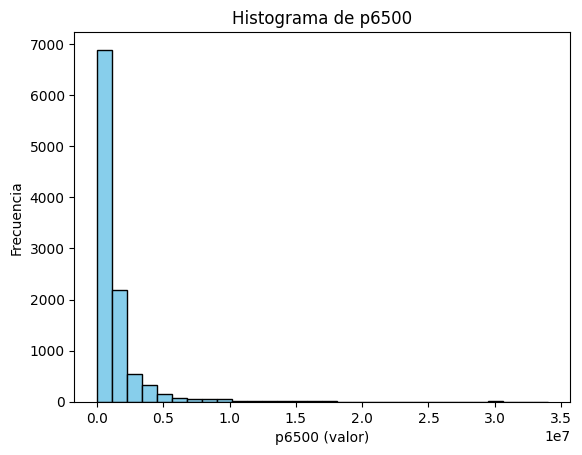

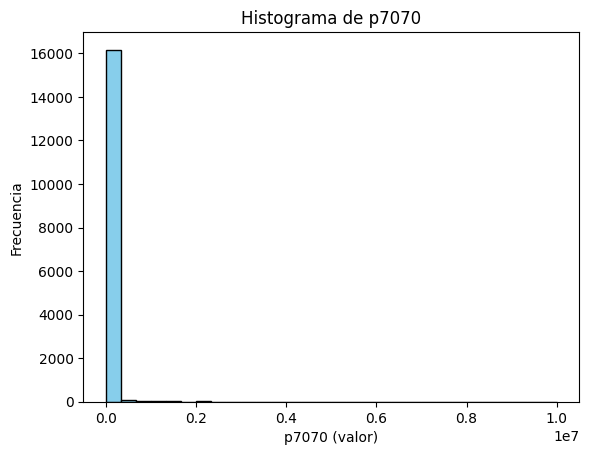

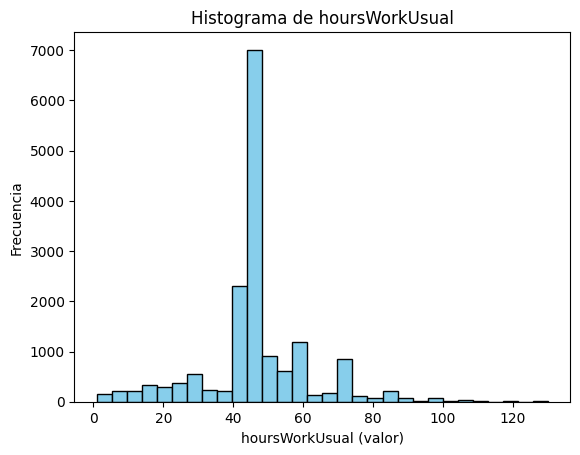

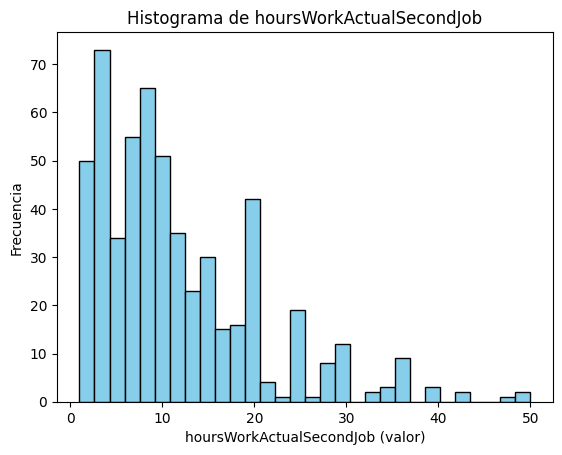

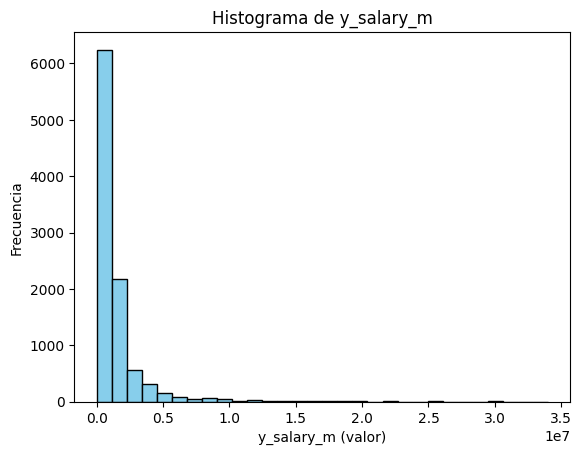

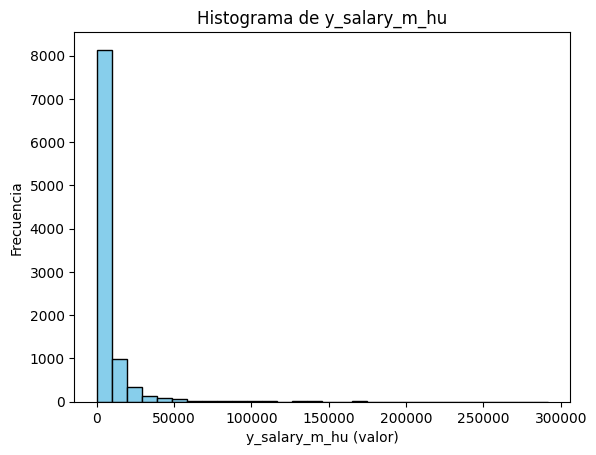

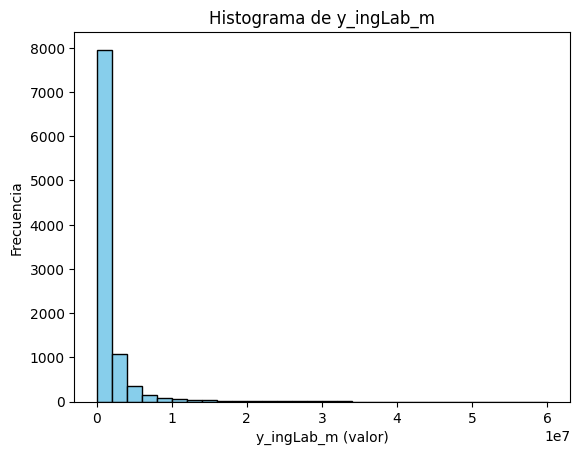

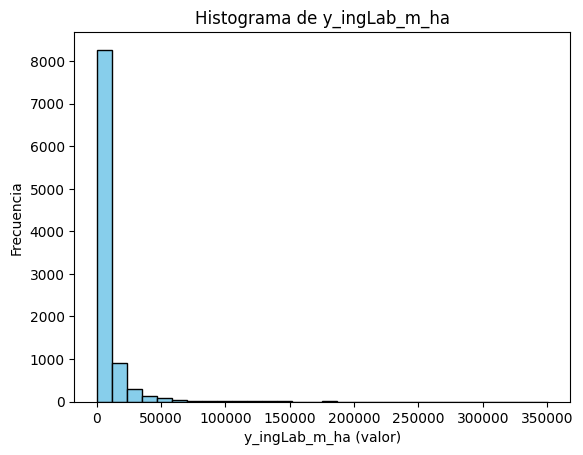

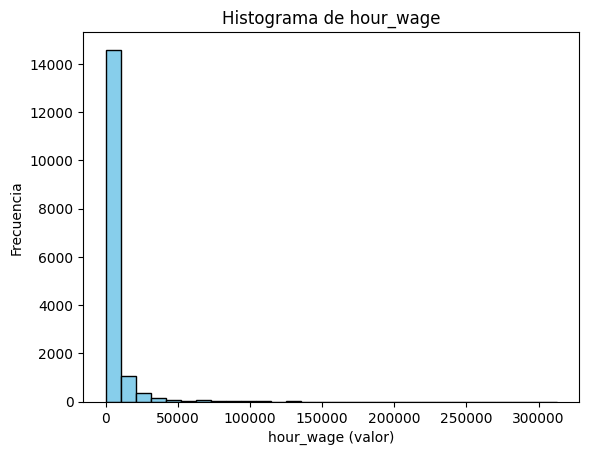

In [35]:
# Histogramas del salario horario

for col in wage_hours_related_vars:
    data = df_limpio[col].dropna()

    # Grafico histogramas
    plt.hist(data, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(f'{col} (valor)')
    plt.ylabel('Frecuencia')
    plt.show()


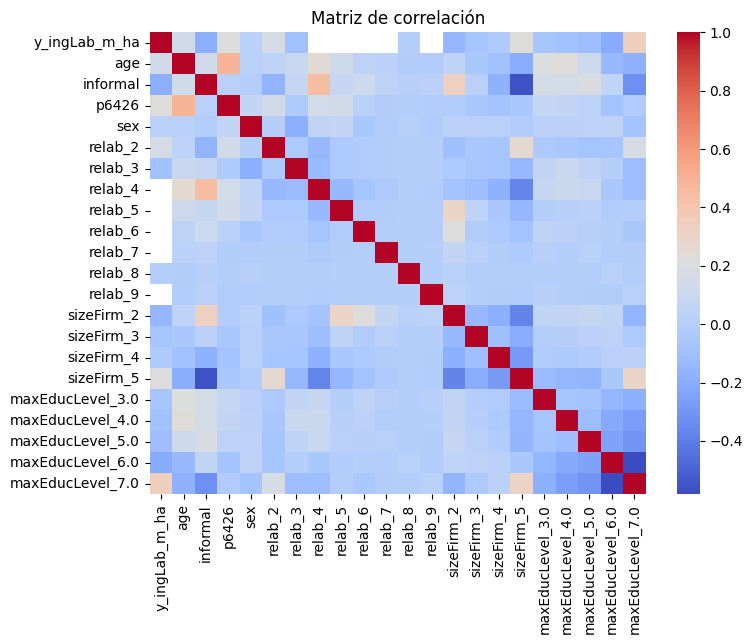

In [36]:
# Calculo y visualizo la matriz de correlación
corr_matrix = subset.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matriz de correlación")
plt.show()

In [ ]:
# Elimino missings

df_limpio = df_limpio[["y_ingLab_m_ha", "age", "informal", "p6426", "relab", "sex", "sizeFirm","maxEducLevel", "oficio"]]
df_limpio = df_limpio.dropna()

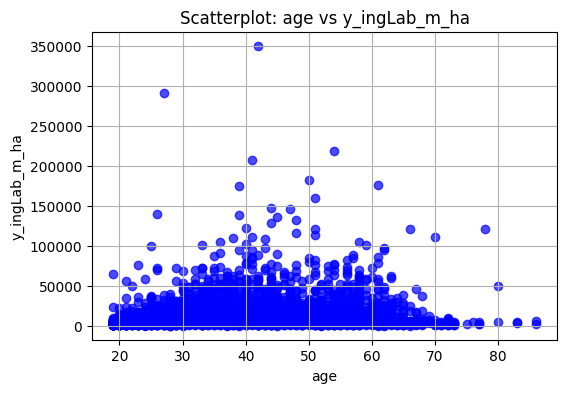

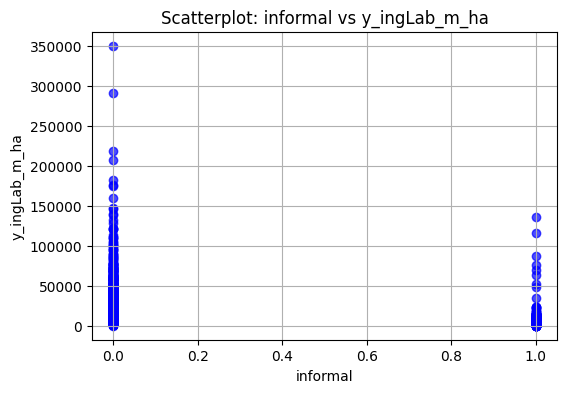

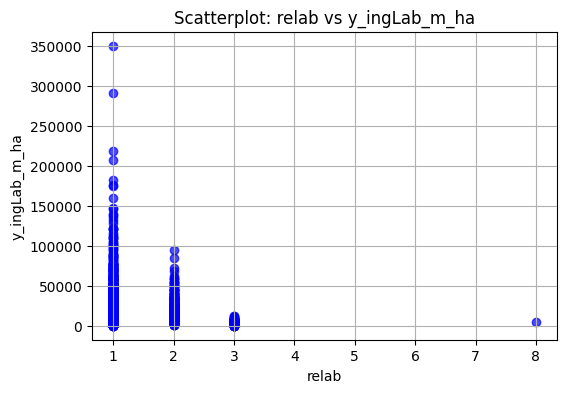

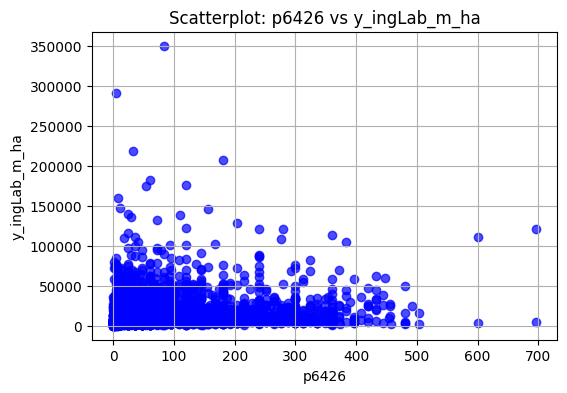

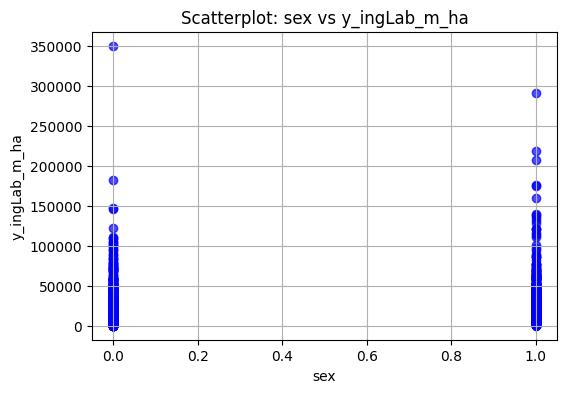

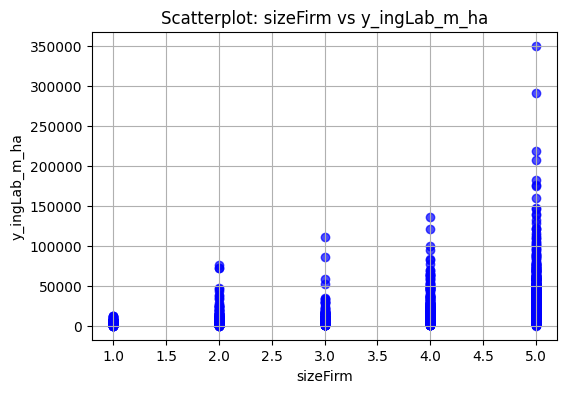

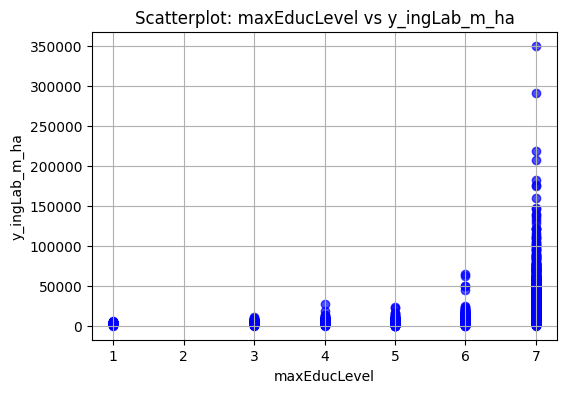

In [37]:
# Defino las variables independientes y la dependiente
variables_independientes = ["age", "informal", "relab", "p6426", "sex", "sizeFirm","maxEducLevel"]

variable_dependiente = "y_ingLab_m_ha"

# Creo scatterplots entre hour_wage y cada variable independiente
for var in variables_independientes:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_limpio[var], df_limpio[variable_dependiente], alpha=0.7, color='b')
    plt.title(f"Scatterplot: {var} vs {variable_dependiente}")
    plt.xlabel(var)
    plt.ylabel(variable_dependiente)
    plt.grid(True)
    plt.show()
